In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm
from sklearn import metrics
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
# data = pd.read_csv("data.csv")
# data = data.sample(frac=1).reset_index(drop=True)
# pd.options.mode.chained_assignment = None


# XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
# X = data[XLabels]
# #Scaling X
# sc = StandardScaler()
# X = sc.fit_transform(X)
# data[XLabels] = X

# papers = data['ID'].unique()
# shuffle(papers)

# #Remvoing papers from test list if they have less  than 10 points
# papersWithLessThanXPoints = []
# for paper in papers:
#     dataFromPaper = data[data['ID'] == paper]
#     if len(dataFromPaper.index) < 10:
#         papersWithLessThanXPoints.append(paper)
# papers = [x for x in papers if x not in papersWithLessThanXPoints]

# numPapers = len(papers)
# papersPerGroup = 2
# numBins = 10

# error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
# numEpoch = 3000

# #10% Seed

# for paper in papers:
#     print(paper)
#     train_Frame = data[data['ID'] != paper]
#     test_Frame = data[data['ID'] == paper]
    

#     ##Seeding with 10
    
#     test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
#     lenTest = len(test_Frame.index)
    
    
#     train_Frame.append(test_Frame.iloc[:int(lenTest * 0.1), :])
#     test_Frame = train_Frame.iloc[int(lenTest * 0.1):, :]

    
    
#     papers = train_Frame['ID'].unique()
    
    
#     numPapers = len(papers)
#     #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
#     combos = []
#     for x in range(0, len(papers), papersPerGroup):
#         if x + papersPerGroup < len(papers):
#             combos.append(papers[x:x + papersPerGroup])
#         else:
#             combos.append(papers[x:])

#     lenTrain = len(train_Frame.index)
#     train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

#     #Calculating Sample Weight
#     bins = train_Frame['Yield'].value_counts(bins=numBins)
#     for i in train_Frame.index:
#         for j in bins.index:
#             if int(train_Frame.at[i, 'Yield']) in j:
#                 train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
#     bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
#     for i in train_valid_Frame.index:
#         for j in bins.index:
#             if int(train_valid_Frame.at[i, 'Yield']) in j:
#                 train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
#     y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
#     X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

#     train_weights = train_Frame['Sample_Weight']
#     train_valid_weights = train_valid_Frame['Sample_Weight']
    

#     ##NN
#     learningRates = [0.002, 0.005, 0.01, 0.02]
#     batchSizes = [128]
#     dropoutRates = [0.00, 0.1]
#     errors = []
#     for lr_ in learningRates:
#         for bs in batchSizes:
#             for dr in dropoutRates:
#                 sumErrors = 0
#                 for c in combos:
#                     train_Frame = train_valid_Frame[~train_valid_Frame['ID'].isin(c)]
#                     valid_Frame = train_valid_Frame[train_valid_Frame['ID'].isin(c)]

#                     ##Calculating Sample Weight again just for train frame, because it's different
#                     bins = train_Frame['Yield'].value_counts(bins=numBins)
#                     for i in train_Frame.index:
#                         for j in bins.index:
#                             if int(train_Frame.at[i, 'Yield']) in j:
#                                 train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

#                     y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
#                     X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

#                     train_weights = train_Frame['Sample_Weight']
                    
#                     model = Sequential()
#                     model.add(Dense(units=12, activation='sigmoid', input_dim=13))
#                     model.add(Dropout(dr))
#                     model.add(Dense(units=12, activation='sigmoid'))
#                     model.add(Dense(units=6, activation='sigmoid'))
#                     model.add(Dense(units=6, activation='sigmoid'))
#                     model.add(Dense(units=1, activation='softplus'))

#                     sgd = SGD(lr=lr_)  
#                     model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

                
#                     model.fit(X_train, y_train, sample_weight=np.asarray(train_weights), epochs=numEpoch, batch_size=bs ,verbose=0)

# #                     loss_and_metrics = model.evaluate(X_valid, y_valid,batch_size=bs)
                    
# #                     print(X_valid)
#                     y_pred = model.predict(X_valid, batch_size=bs)
#                     y_pred = y_pred.flatten()
#                     error =  metrics.mean_absolute_error(y_valid, y_pred)
#                     sumErrors = sumErrors + error
#                 errors.append(sumErrors)
#     index_of_lowest_error = np.argmin(errors)
          
#     print("Lowest Error In Validation _MSE_ ", np.min(errors))

#     best_lr = learningRates[int(index_of_lowest_error / (len(batchSizes) * len(dropoutRates)))] #Good
#     best_bs = batchSizes[int((index_of_lowest_error % (len(batchSizes) * len(dropoutRates)))/len(dropoutRates))] #Good
#     best_dr = dropoutRates[int(index_of_lowest_error % len(dropoutRates))] #Good 
#     print("Best Learning Rate is: ",best_lr)
#     print("Best Batch Size is: ", best_bs)
#     print("Best Dropout Rate is: ", best_dr)    


#     #Using best values

#     model = Sequential()
#     model.add(Dense(units=12, activation='sigmoid', input_dim=13))
#     model.add(Dropout(best_dr))
#     model.add(Dense(units=12, activation='sigmoid'))
#     model.add(Dense(units=6, activation='sigmoid'))
#     model.add(Dense(units=6, activation='sigmoid'))
#     model.add(Dense(units=1, activation='softplus'))

#     sgd = SGD(lr=best_lr)  
#     model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

#     model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

#     loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

#     y_pred = model.predict(X_test, batch_size=best_bs)
#     y_pred = y_pred.flatten()
          
#     mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

#     row = [[paper, mseNN]]
#     tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
#     error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
#     error_Frame.index = error_Frame['ID'].values
#     error_Frame = error_Frame.sort_index()
#     error_Frame.to_csv("10SeedCrossValidNN.csv")


    
# error_Frame.reset_index()
# error_Frame.index = error_Frame['ID'].values
# error_Frame = error_Frame.sort_index()


# error_Frame.plot(kind='bar', stacked=False)
# error_Frame.to_csv("10SeedCrossValidNN.csv")

# plt.ylabel('Mean Absolute Error (Yield %)')
# plt.title("10% Seed")
# plt.savefig("10Seed", dpi=600, bbox_inches='tight')



J
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
54/54 [==============================] - 0s 4ms/step
K
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
20/20 [==============================] - 0s 12ms/step
M
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
52/52 [==============================] - 0s 5ms/step
N
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
68/68 [==============================] - 0s 4ms/step
O
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
18/18 [==============================] - 0s 14ms/step
A
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
26/26 [==============================] - 0s 10ms/step
I
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
17/17 [==============================] - 0s 17ms/step
E
Best Learning Rate is:  0.02
Best Batch Si

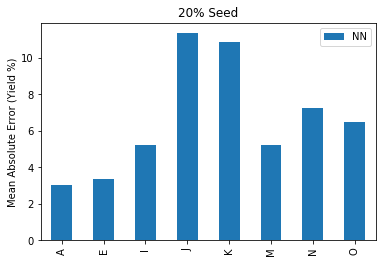

In [11]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 20:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#20% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 20
    
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    train_Frame = train_Frame.append(test_Frame.iloc[:int(lenTest * 0.2), :])
    test_Frame = test_Frame.iloc[int(lenTest * 0.2):, :]
    
    
    train_Frame = train_Frame.sample(frac=1).reset_index(drop=True)
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)


    
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    


    best_lr = 0.02
    best_bs = 128
    best_dr = 0.0
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("20SeedCrossValidNN.csv")


    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
error_Frame.to_csv("20SeedCrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("20% Seed")
plt.savefig("20SeedCrossValidNN", dpi=600, bbox_inches='tight')




E
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
200/200 [==============================] - 0s 1ms/step
N
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
43/43 [==============================] - 0s 7ms/step
I
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
11/11 [==============================] - 0s 27ms/step
M
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
33/33 [==============================] - 0s 10ms/step
O
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
11/11 [==============================] - 0s 31ms/step
A
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
16/16 [==============================] - 0s 22ms/step
J
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
34/34 [==============================] - 0s 10ms/step
K
Best Learning Rate is:  0.02
Best Batch

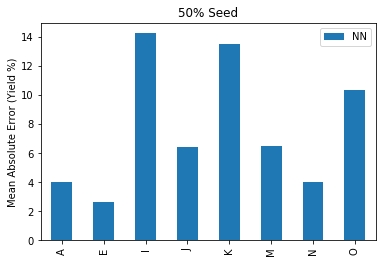

In [12]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 20:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#50% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 50
    
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    
    
    train_Frame = train_Frame.append(test_Frame.iloc[:int(lenTest * 0.5), :])
    test_Frame = test_Frame.iloc[int(lenTest * 0.5):, :]
    
        
    train_Frame = train_Frame.sample(frac=1).reset_index(drop=True)
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)

    
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    


    best_lr = 0.02
    best_bs = 128
    best_dr = 0.1
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("50SeedCrossValidNN.csv")


    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
error_Frame.to_csv("50SeedCrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("50% Seed")
plt.savefig("50SeedCrossValidNN", dpi=600, bbox_inches='tight')




In [15]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 20:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#50% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 0

    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    
    
    train_Frame = train_Frame.append(test_Frame.iloc[:int(lenTest * 0.0), :])
    print(test_Frame.iloc[:int(lenTest * 0.0), :])
    test_Frame = test_Frame.iloc[int(lenTest * 0.0):, :]
    
        
    train_Frame = train_Frame.sample(frac=1).reset_index(drop=True)
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)

    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    


    best_lr = 0.02
    best_bs = 128
    best_dr = 0.1
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

#     row = [[paper, mseNN]]
#     tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
#     error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
#     error_Frame.index = error_Frame['ID'].values
#     error_Frame = error_Frame.sort_index()
#     error_Frame.to_csv("0SeedCrossValidNN.csv")


    
# error_Frame.reset_index()
# error_Frame.index = error_Frame['ID'].values
# error_Frame = error_Frame.sort_index()


# error_Frame.plot(kind='bar', stacked=False)
# error_Frame.to_csv("0SeedCrossValidNN.csv")

# plt.ylabel('Mean Absolute Error (Yield %)')
# plt.title("0% Seed")
# plt.savefig("0SeedCrossValidNN", dpi=600, bbox_inches='tight')




K
Empty DataFrame
Columns: [TotalT, Temp, LSR, CA, Size, Mass, Moisture, IsoT, HeatT, Ramp, F_A, F_Gal, F_Glu, F_X, F_M, F_R, A, Gal, Glu, X, M, R, Furf, HMF, Source, ID, Yield, P, logP, Ro, logRo]
Index: []

[0 rows x 31 columns]
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1


KeyboardInterrupt: 

N
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
77/77 [==============================] - 0s 5ms/step
O
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
20/20 [==============================] - 0s 21ms/step
A
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
29/29 [==============================] - 1s 19ms/step
K
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
22/22 [==============================] - 0s 18ms/step
I
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
19/19 [==============================] - 0s 22ms/step
J
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
61/61 [==============================] - 0s 6ms/step
M
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
59/59 [==============================] - 0s 7ms/step
E
Best Learning Rate is:  0.02
Best Batch Si

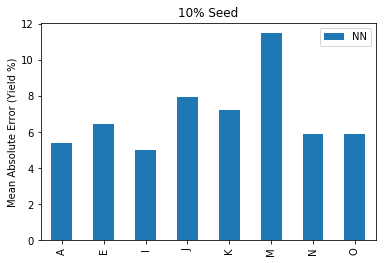

In [13]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 20:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#10% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 10
    
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    
    
    train_Frame = train_Frame.append(test_Frame.iloc[:int(lenTest * 0.1), :])
    test_Frame = test_Frame.iloc[int(lenTest * 0.1):, :]

    
    train_Frame = train_Frame.sample(frac=1).reset_index(drop=True)
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    


    best_lr = 0.02
    best_bs = 128
    best_dr = 0.1
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("10SeedCrossValidNN.csv")


    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
error_Frame.to_csv("10SeedCrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("10% Seed")
plt.savefig("10SeedCrossValidNN", dpi=600, bbox_inches='tight')




In [ ]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if paper != 'E':
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]
print(papersWithLessThanXPoints)
print(papers)

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#10% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 0
    
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    
    
    train_Frame = train_Frame.append(test_Frame.iloc[:int(lenTest * 0.0), :])
    test_Frame = test_Frame.iloc[int(lenTest * 0.0):, :]

    
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    


    best_lr = 0.005
    best_bs = 128
    best_dr = 0.1
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
#     error_Frame.to_csv("000Test.csv")


    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
# error_Frame.to_csv("000Test.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("0% Seed")
# plt.savefig("000Test", dpi=600, bbox_inches='tight')




['P', 'B', 'G', 'F', 'L', 'C', 'D', 'H']
['K', 'J', 'N', 'A', 'M', 'E', 'O', 'I']
K
Best Learning Rate is:  0.01
Best Batch Size is:  128
Best Dropout Rate is:  0.1
24/24 [==============================] - 1s 21ms/step
J
Best Learning Rate is:  0.01
Best Batch Size is:  128
Best Dropout Rate is:  0.1
67/67 [==============================] - 1s 13ms/step
N
Best Learning Rate is:  0.01
Best Batch Size is:  128
Best Dropout Rate is:  0.1
85/85 [==============================] - 1s 7ms/step
A
Best Learning Rate is:  0.01
Best Batch Size is:  128
Best Dropout Rate is:  0.1
32/32 [==============================] - 1s 23ms/step
M
Best Learning Rate is:  0.01
Best Batch Size is:  128
Best Dropout Rate is:  0.1
65/65 [==============================] - 1s 16ms/step
E
Best Learning Rate is:  0.01
Best Batch Size is:  128
Best Dropout Rate is:  0.1
400/400 [==============================] - 1s 2ms/step
O
Best Learning Rate is:  0.01
Best Batch Size is:  128
Best Dropout Rate is:  0.1
22/22 [======

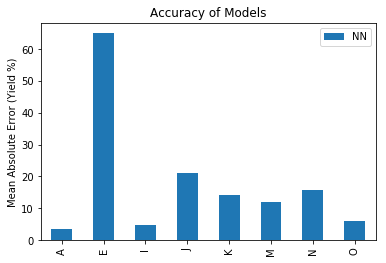

In [14]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Just Testing E

papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 20:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]
print(papersWithLessThanXPoints)
print(papers)
numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    

    best_lr = 0.01
    best_bs = 128
    best_dr = 0.1
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
#     error_Frame.to_csv("CrossValidNN.csv")

    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
# error_Frame.to_csv("CrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("Accuracy of Models")
plt.savefig("CrossValidNN.png", dpi=600, bbox_inches='tight')


['M', 'K', 'F', 'G', 'C', 'L', 'P', 'B', 'O', 'H', 'N', 'I', 'D', 'A', 'J']
['E']
E
Lowest Error In Validation _MSE_  126.00105601345481
Best Learning Rate is:  0.01
Best Batch Size is:  128
Best Dropout Rate is:  0.1
400/400 [==============================] - 2s 5ms/step


Text(0.5,1,'Accuracy of Models')

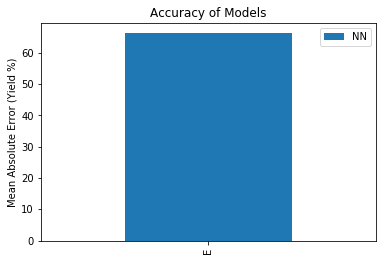

In [16]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Just Testing E

papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if paper != 'E':
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]
print(papersWithLessThanXPoints)
print(papers)
numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    

    ##NN
    learningRates = [0.002, 0.005, 0.01, 0.02]
    batchSizes = [128]
    dropoutRates = [0.00, 0.1]
    errors = []
    for lr_ in learningRates:
        for bs in batchSizes:
            for dr in dropoutRates:
                sumErrors = 0
                for c in combos:
                    train_Frame = train_valid_Frame[~train_valid_Frame['ID'].isin(c)]
                    valid_Frame = train_valid_Frame[train_valid_Frame['ID'].isin(c)]

                    ##Calculating Sample Weight again just for train frame, because it's different
                    bins = train_Frame['Yield'].value_counts(bins=numBins)
                    for i in train_Frame.index:
                        for j in bins.index:
                            if int(train_Frame.at[i, 'Yield']) in j:
                                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

                    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
                    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

                    train_weights = train_Frame['Sample_Weight']
                    
                    model = Sequential()
                    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
                    model.add(Dropout(dr))
                    model.add(Dense(units=12, activation='sigmoid'))
                    model.add(Dense(units=6, activation='sigmoid'))
                    model.add(Dense(units=6, activation='sigmoid'))
                    model.add(Dense(units=1, activation='softplus'))

                    sgd = SGD(lr=lr_)  
                    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

                
                    model.fit(X_train, y_train, sample_weight=np.asarray(train_weights), epochs=numEpoch, batch_size=bs ,verbose=0)

#                     loss_and_metrics = model.evaluate(X_valid, y_valid,batch_size=bs)
                    
#                     print(X_valid)
                    y_pred = model.predict(X_valid, batch_size=bs)
                    y_pred = y_pred.flatten()
                    error =  metrics.mean_absolute_error(y_valid, y_pred)
                    sumErrors = sumErrors + error
                errors.append(sumErrors)
    index_of_lowest_error = np.argmin(errors)
          
    print("Lowest Error In Validation _MSE_ ", np.min(errors))

    best_lr = learningRates[int(index_of_lowest_error / (len(batchSizes) * len(dropoutRates)))] #Good
    best_bs = batchSizes[int((index_of_lowest_error % (len(batchSizes) * len(dropoutRates)))/len(dropoutRates))] #Good
    best_dr = dropoutRates[index_of_lowest_error % len(dropoutRates)] #Good 
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
#     error_Frame.to_csv("CrossValidNN.csv")

    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
# error_Frame.to_csv("CrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("Accuracy of Models")
# plt.savefig("CrossValidNN.png", dpi=600, bbox_inches='tight')
